In [5]:
import torch
import xnat
import pydicom
import json
import matplotlib.pyplot as plt


from pyxnat import Interface
from torch.utils.data import Dataset

# Goal: Build PyTorch Dataloader to access data over API


In [ ]:
xnat_address = 'http://10.2.0.9'
xnat_username = 'admin'
xnat_password = 'admin'
xnat_project = 'padchest'

### XNAT Subject DataSet
This dataset allows it's consumer to iterate over subject level data in an XNAT project. Please note we haven't added any labels at the subject level so it doesn't return any labels.

In [6]:
class XnatSubjectDataset(Dataset):
    def __init__(self, xnat_client, project_name: str):
        self._xnat_client = xnat_client
        self._project_name = project_name
        self._xnat_project = xnat_client.projects[project_name]
        self._subjects = self._xnat_project.subjects
    
    def __len__(self):
        return len(self._subjects)
    
    def __getitem__(self, idx):
        return self._subjects[idx], None   

In [7]:
xnat_client = xnat.connect(xnat_address, user=xnat_username, password=xnat_password)

In [8]:
xnat_dataset = XnatSubjectDataset(xnat_client, xnat_project)


In [5]:
for subject, label in xnat_dataset:
    print(subject, label)

<SubjectData Towne435_Napoleon578 (XNAT03_S00090)> None
<SubjectData Ernser583_Catarina933 (XNAT03_S00091)> None
<SubjectData Bosco882_Marcus77 (XNAT03_S00092)> None
<SubjectData Brown30_Chi716 (XNAT03_S00093)> None
<SubjectData Eichmann909_Jc393 (XNAT03_S00094)> None
<SubjectData Marquardt819_Roselia779 (XNAT03_S00095)> None
<SubjectData Conroy74_Mammie808 (XNAT03_S00096)> None
<SubjectData Brakus656_Lorenzo669 (XNAT03_S00097)> None
<SubjectData P_rez790_Leonor133 (XNAT03_S00098)> None
<SubjectData Dicki44_Theron432 (XNAT03_S00099)> None
<SubjectData Ankunding277_Cythia210 (XNAT03_S00100)> None
<SubjectData Gibson10_Dante562 (XNAT03_S00101)> None
<SubjectData Wiegand701_Von197 (XNAT03_S00102)> None
<SubjectData Walker122_Robena997 (XNAT03_S00103)> None
<SubjectData Becker968_Val761 (XNAT03_S00104)> None
<SubjectData Lehner980_Ahmad985 (XNAT03_S00105)> None
<SubjectData Simonis280_Lynda214 (XNAT03_S00106)> None
<SubjectData MacGyver246_Laverne101 (XNAT03_S00107)> None
<SubjectData Cruz

### XNAT Scan DataSet
Allows consumers to iterate over all the scans and it's corresponding label in a project. It assumes that for each scan the label is available in the `LABEL` directory

#### Data Organization
This notebook assumes that the data is organized in the following manner:
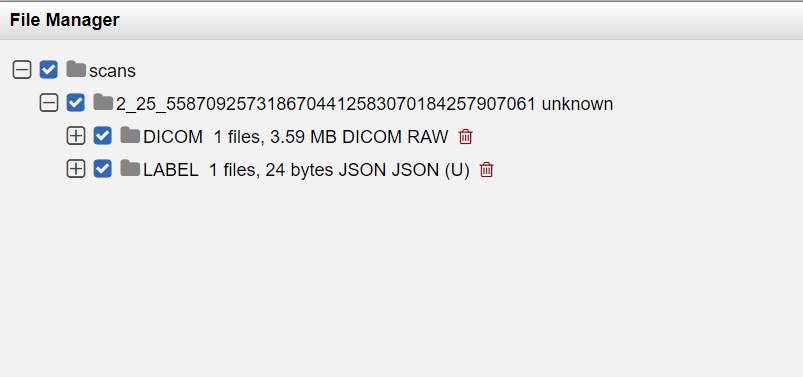

i.e. For each scan we have the images stored in the `DICOM` directory. XNAT does this for us automatically
We upload the associated label in a directory called `LABEL`. 

In [11]:
class XNATScanDataset(Dataset):
    def __init__(self, xnat_interface, project_name: str):
        self._xnat_interface = xnat_interface
        self._scans = list(xnat_interface.select(f'/projects/{project_name}/subject/*/experiments/*/scans'))
        self._dicom_label = 'DICOM'
        self._label_label = 'LABEL'
        self._temp_fs = '/tmp'
    def __len__(self):
        return len(self._scans)
        
    def __getitem__(self, idx):
        scan = self._scans[idx]
        img, label = None, None
        for resource in scan.resources():
            if resource.label() == self._dicom_label:
                for file in resource.files():
                    temp_file = f'{self._temp_fs}/{file.id()}'
                    file.get(temp_file)
                    img = pydicom.dcmread(temp_file)
            elif resource.label() == self._label_label:
                for file in resource.files():
                    filename = f'{self._temp_fs}/{file.id()}'
                    file.get(filename)
                    label = json.load(open(filename))

        return img, label

In [12]:
interface = Interface(xnat_address, xnat_username, xnat_password)

xnat_scan_ds = XNATScanDataset(interface, xnat_project)

### Iterating over scan data
Following script demonstrates accessing over the first 20 scans in the project and rendering the images

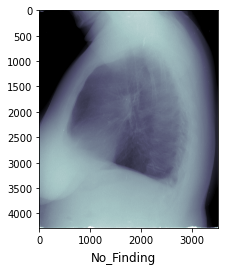

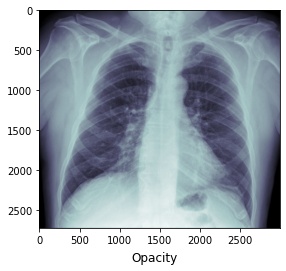

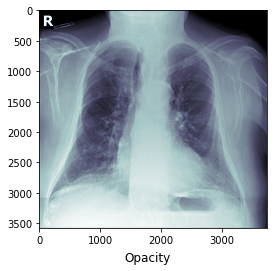

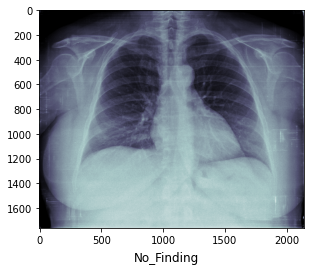

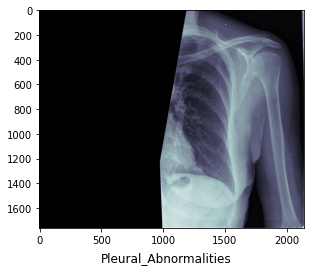

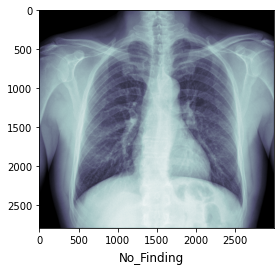

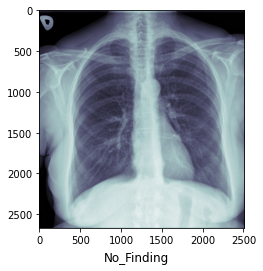

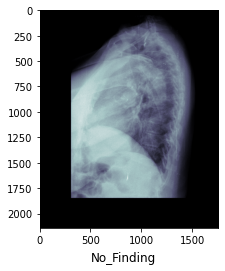

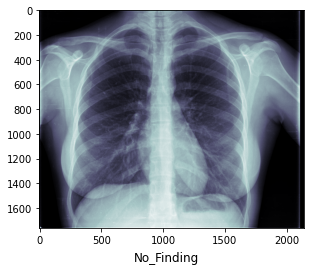

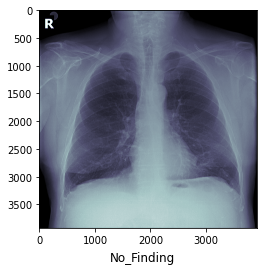

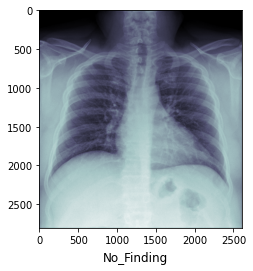

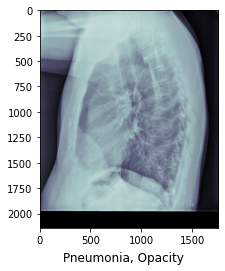

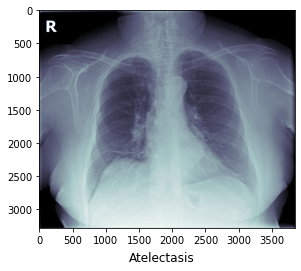

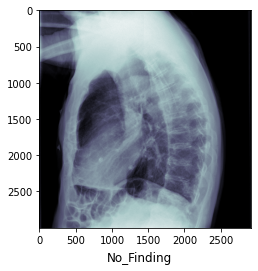

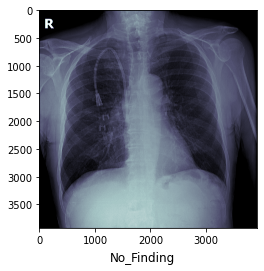

In [8]:
for i in range(0, 20):
    img, label = xnat_scan_ds[i]
    if not img: continue
    try:
        txt = ', '.join(label)
        plt.figure()
        plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=12)
        plt.imshow(img.pixel_array, cmap=plt.cm.bone)
    except Exception as e:
        print(f'Failed to render {e}')


In [13]:
def get_first_n(n):
    for i in range(0, n):
        img, label = xnat_scan_ds[i]

In [15]:
%timeit -r 5 -n 1 get_first_n(20)

20.4 s ± 1.4 s per loop (mean ± std. dev. of 5 runs, 1 loop each)
